# Introduction

I used this notebook to train models so that I could then compare and select the best performing model.

# Imports

In [5]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from air_quality.model import Model
import air_quality.utils as aqutils

# Data load

First we load the processed datasets (of pollutant concentration, weather forecast data and historical weather data.)

In [6]:
loaded_datasets = {}

paths = {
    'historical_weather' : 'data/Historical weather/Historical to 2022-08-29/Processed historical weather data.pkl',
    'weather_forecast' : 'data/Weather forecast/Historical to 2022-08-29/Processed weather forecast data.pkl',
    'air_quality' : 'data/Air Quality/Historical to 2022-08-29/Processed pollutants data.pkl'
}

for key, path in paths.items():
    with open(path, 'rb') as file:
        dataframe = pickle.load(file)

        category_col_name = dataframe.columns[0]
        
        df = dataframe.pivot_table(
            index = [category_col_name, 'Datetime'],
            dropna = False
        )

        timeseries = {}
        for category in df.index.get_level_values(0).unique():
            timeseries[category] = TimeSeries.from_dataframe(df.loc[category])

        loaded_datasets[key] = timeseries

# Division into datasets and scaling

We convert our loaded data into a form ready for training by the model.

The `aqutils.get_sliced_datasets` function splits and scales our datasets using a default split into train, validation and test sets of 80%, 10% and 10%.

We can also choose to shorten the dataset for faster training by using the second parameter of `aqutils.get_sliced_datasets` to specify a start date.

In [7]:
datasets = aqutils.get_sliced_datasets(loaded_datasets, '')

# Define model

We define the number of days we wish the model to forecast.

In [8]:
FORECAST_DAYS = 1

We also define various characteristics of the data the model will be trained on:
- `training_type`: can be one of 'VAL' or 'TEST. This specifies whether we are in 'validation' or 'test' mode. In 'validation' mode - (used for selecting and tuning a model) we train on the 'train' data and validate on the 'validation' data, while the 'test' data remains unseen. In 'test' mode we train on 'train' and 'validation' data combined, and we validate (for early stopping) on the 'test' data.
- `forecast_pollutants`: a list of which pollutant(s) to train on. In the end I trained a model for each pollutant as I found the performance was not quite as good when training on several pollutants at once.
- `covariates_types`: which combination of 'past' and 'future' covariates (i.e., weather data and/or seasonal time data) to train with. Different models can use different types of covariates so this choice is automatically overridden where necessary later on. (For example, Transformers cannot use future covariates, so a selection of 'future' would be ignored. This is useful for evaluating which types of covariates improve prediction.
- `feature_covariates`: which combination of covariates types to train on. 'data' means the weather data (forecast and historical) while time means seasonal time information of hour, day of week, and month. This is useful for evaluating which types of covariates improve prediction.

In [9]:
DATA_CHOICES = {
    'training_type' : 'VAL',
    'forecast_pollutants' : ['NO2'],
    'covariates_types' : ['past', 'future'],
    'feature_covariates' : ['time', 'data'],
}

In [10]:
model_dataset = aqutils.get_model_dataset(
    datasets,
    DATA_CHOICES
)

We can check that our data selections are as expected by looking at the first and last values of the timeseries, first for our target series of pollutant concentration...

In [11]:
first_last_target_dfs = model_dataset.get_first_last_target_series()
for df in first_last_target_dfs:
    display(df)

component,Concentration
Datetime,
2013-01-02 00:00:00,7.666667
2020-09-23 13:00:00,25.137501


component,Concentration
Datetime,
2020-09-23 14:00:00,25.893749
2021-09-11 06:00:00,22.031250


component,Concentration
Datetime,
2013-01-02 00:00:00,7.666667
2021-09-11 06:00:00,22.031250


... and then for the covariates data

In [12]:
first_last_cov_dfs = model_dataset.get_first_last_covariates()
for df in first_last_cov_dfs:
    display(df)

component,dwpt,pres,rhum,temp,wdir,wspd,hour,day_of_week,month
Datetime,,,,,,,,,
2013-01-02 00:00:00,3.800000,1018.400024,68.000000,9.400000,340.000000,11.200000,0.000000,2.000000,1.000000
2021-09-11 06:00:00,15.200000,1018.299988,86.000000,17.600000,340.000000,7.600000,6.000000,5.000000,9.000000


component,DewPointC,cloudcover,humidity,pressure,tempC,winddirDegree,windspeedKmph,hour,day_of_week,month
Datetime,,,,,,,,,,
2013-01-02 00:00:00,5.000000,11.000000,78.000000,1019.000000,8.000000,305.000000,29.000000,0.000000,2.000000,1.000000
2021-09-11 06:00:00,13.000000,6.000000,73.000000,1018.000000,18.000000,339.000000,9.000000,6.000000,5.000000,9.000000


Now we define the model characteristics:
- `model_name`: - the key used to look up the model parameters in the file `Models parameters/Models parameters.csv`. In that file (easily examined using Excel for example, we can define each model we want to train using the various parameters applicable to that model.
- `model_save_path`: where the trained model will be saved (relative to this notebook's location).
- `forecast_horizon`: the number of hours we want the model to forecast. (Effectively already set by the choice of `FORECAST_DAYS`.
- `max_epochs`: the maximum number of epochs to be used for training. Usually left unset, but can be set to a low number just for testing purposes if needed.
- `log_tensorboard`: whether to log tensorboard results. This generally set to `False`, because I could not find a way to set the tensorboard logs directory within Darts so that the saved model could then be moved and the tensorboard logs be moved with it. However in this example I have set to `True` so that the outputs can be seen.

In [13]:
MODEL_CHOICES = {
    'model_name' : 'TFT Base Deterministic',
    'model_save_path' : 'Models comparisons/Example',
    'forecast_horizon' : FORECAST_DAYS * 24,
    'log_tensorboard' : True,
#     'max_epochs' : 1,
}

In [14]:
model_kwargs = {**MODEL_CHOICES, **model_dataset.get_model_input()}

In [15]:
aq_model = Model(**model_kwargs)

# Train model

In [16]:
aq_model.train_and_save()

2022-10-17 09:59:39 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-10-17 09:59:39 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-10-17 09:59:39 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-10-17 09:59:39 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs
2022-10-17 09:59:39 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | criterion                         | MSELoss                          | 0     
1  | train_metrics                     | MetricCollection                 | 0     
2  | val_metrics                       | MetricCollection                 | 0     
3  | input_embeddings                  | _MultiEmbedding                  | 0     
4  | static_covariates_v

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Saving the model to: Models comparisons/Example


We can choose to load a saved model at this point instead if we prefer.

In [17]:
# aq_model = Model.load_model('New Prediction final/NO2')

The `Model` class I developed that we have been using is a wrapper for the Darts model. Since we (typically) train using an early stopper (with a default patience of 5 epochs), the last iteration of the model is not necessarily the best. So here we fetch the version of the model that performed the best according to our chosen validation metric.

In [19]:
best_darts_model = aq_model.get_best_darts_model()

## Tensorboard

In [20]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [21]:
tensorboard_logdir = aq_model.get_tensorboard_log_dir()
%tensorboard --logdir "$tensorboard_logdir"

# Model performance quick look

We can take a quick look at the results here just to get a feel for how this particular model is performing. This is more of a sense check that we are getting results that we might expect. The real analysis and comparison is in the notebook 'Model comparison'.

### Validation period forecast

First we display a forecast for the entire validation period.

In [22]:
trained_model = aq_model

In [23]:
model_pred_series = trained_model.get_validation_period_forecast(
    trained_model.get_best_darts_model()
)

2022-10-17 10:36:51 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-10-17 10:36:51 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-10-17 10:36:51 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-10-17 10:36:51 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

If we have trained on more than one series then we need to select the right prediction series.

In [24]:
PREDICT_SERIES = 'NO2'

In [25]:
pred_ts_sequence_index = trained_model.target_series_names.index(PREDICT_SERIES)

In [26]:
if isinstance(model_pred_series, list):
    pred_series = model_pred_series[pred_ts_sequence_index]
else:
    pred_series = model_pred_series

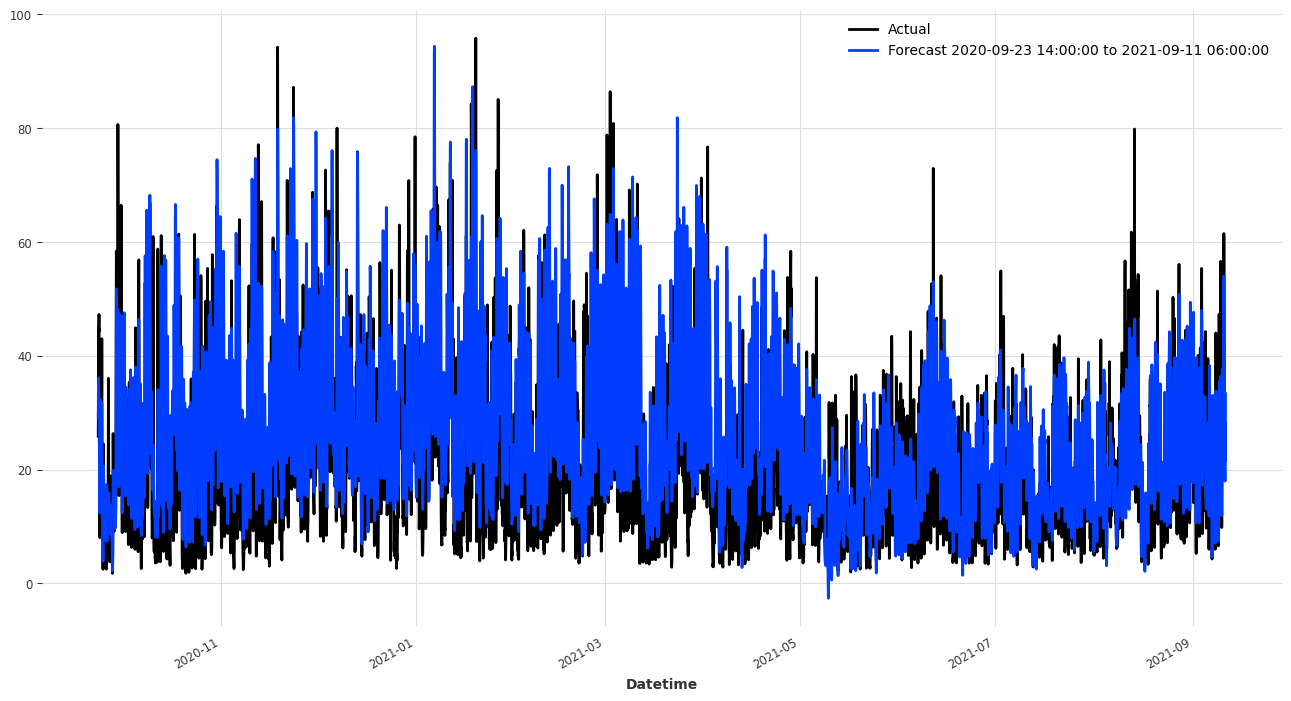

In [27]:
trained_model.plot_forecasts(
    pred_series,
    predict_series = PREDICT_SERIES
)

### 5 day forecast

Now we display a forecast for the first five days of the validation period.

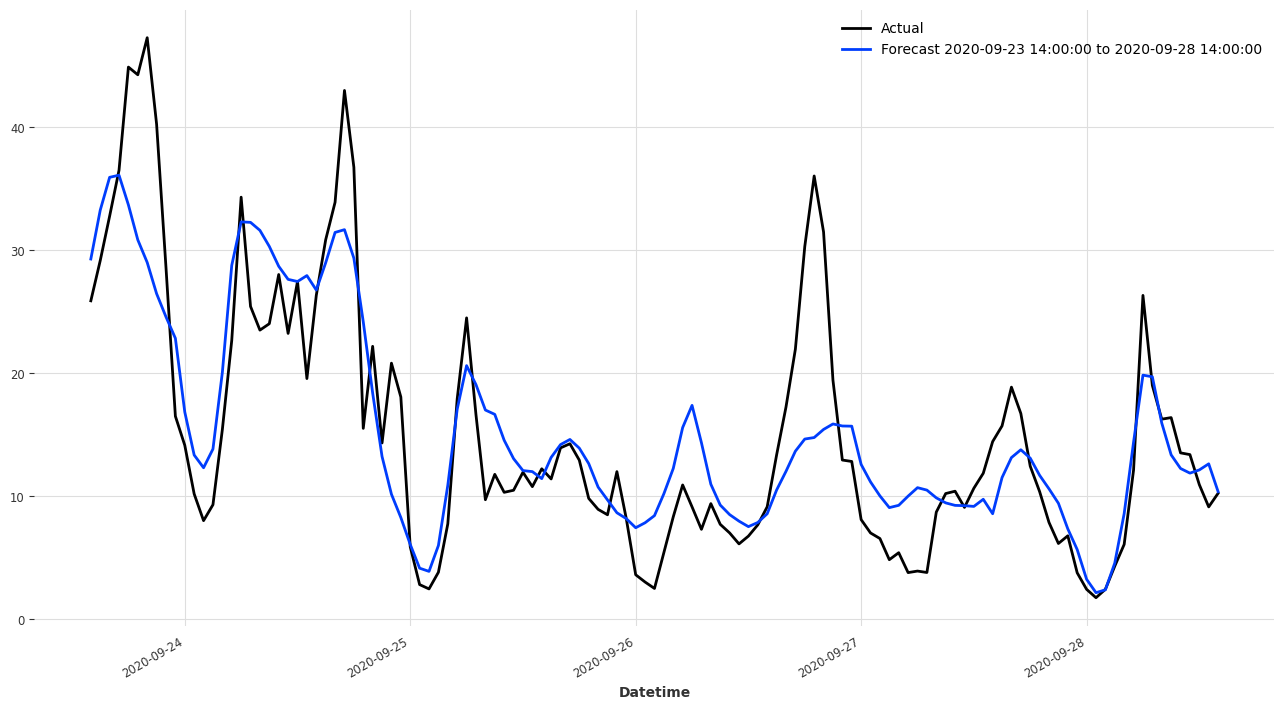

In [28]:
trained_model.plot_forecasts(
    pred_series.slice(pred_series.start_time(), pred_series.time_index[5*24]),
    predict_series = PREDICT_SERIES
)

### Historical forecasts

We can also display historical a series of forecasts, each starting on a new date. Here we choose to show the first three daily forecasts at the beginning of the validation period.

In [29]:
historical_forecasts = trained_model.get_historical_forecast(
    target_series = trained_model.target_series_train_val,
    predict_series = PREDICT_SERIES,
    darts_model = best_darts_model,
    start = '2020-09-23 14:00:00'
)

2022-10-17 10:37:11 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-10-17 10:37:11 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-10-17 10:37:11 pytorch_lightning.utilities.rank_zero INFO: IPU available: False, using: 0 IPUs
2022-10-17 10:37:11 pytorch_lightning.utilities.rank_zero INFO: HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [30]:
window = trained_model.get_historical_forecast_window(
    historical_forecasts,
    start = '2020-09-23 14:00:00',
    end = '2020-09-25 14:00:00',
)

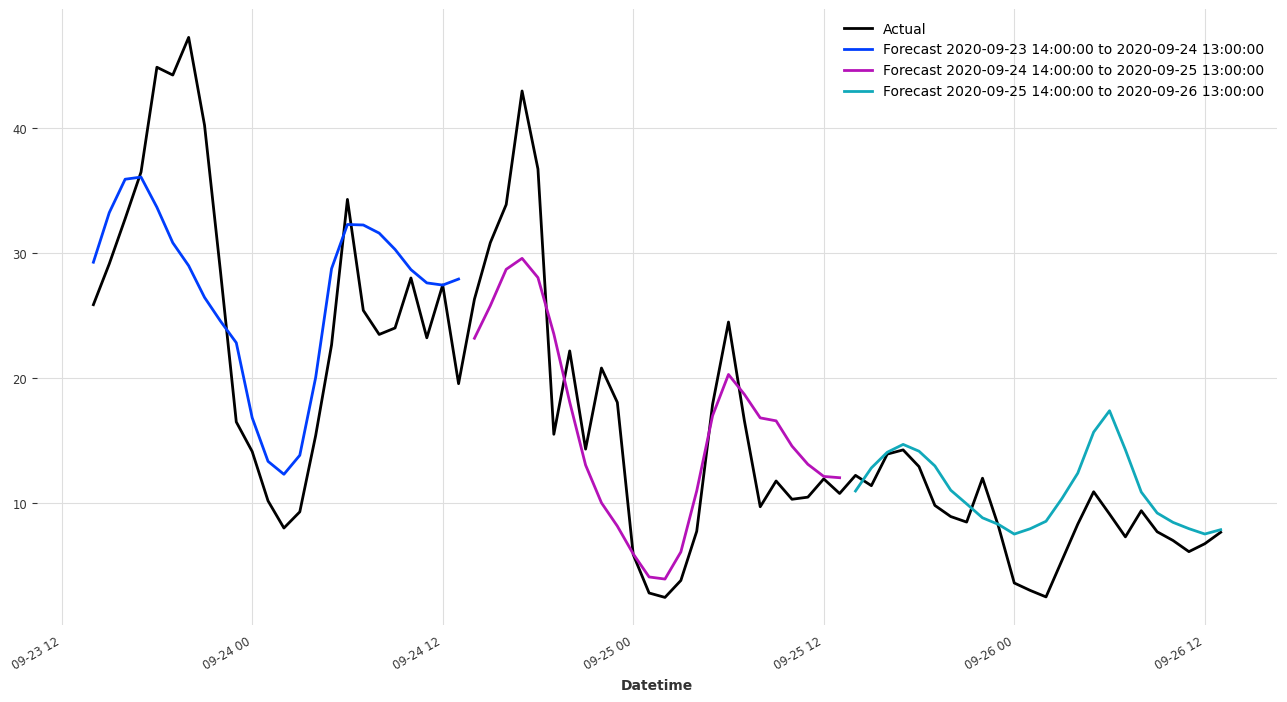

In [31]:
trained_model.plot_forecasts(
    window,
    predict_series = PREDICT_SERIES
)

We can also see the performance metrics (MAPE and MAE) for the historical forecasts - both for each individual daily forecast and for the aggregate result of all three forecasts.

In [32]:
metrics = trained_model.get_metrics(
    window,
    predict_series = PREDICT_SERIES
)

In [33]:
metrics

{'MAPE': {'individual': [24.38472956418991,
   29.96586561203003,
   46.60153388977051],
  'aggregate': 33.65070968866348},
 'MAE': {'individual': [5.841452, 4.387464, 2.738344], 'aggregate': 4.32242}}